In [151]:
#imports


from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import os

/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/bstc/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bstc/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/

## Hyperparameters

In [28]:
batch_size = 1000   # num of training examples to train on in a batch
limit_timesteps = 15 # sequence length
num_hidden_layers = 51
state_dim = 3 # dimensions of the state variable passed as input to the LSTM model
future = 5

## Define PyTorch RNN Model

In [95]:
# Sequence model
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(state_dim, num_hidden_layers)
        self.lstm2 = nn.LSTMCell(num_hidden_layers, num_hidden_layers)
        self.linear = nn.Linear(num_hidden_layers, state_dim)

    def forward(self, input, future = 0):
        outputs = []
        
        h_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        
        # run 19 times
        # input_t.size = 5 x 5
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            input_t = input_t.squeeze(1)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            if (future == 0):
                outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        print(outputs.size())
        return outputs

### Load data that will be used to train the model

In [120]:
# load data and make training set
data = pd.read_csv('cleaned/states_2017-08-28-00.csv')

# # drop unneeded columns to form matrix to be trained on
# data_matr = data.drop(['NMAC_id', 'alert_1', 'alert_2', 'onground_1', 'onground_2'], axis=1).as_matrix().astype('float')

# restructure data
all_planes = []

count = 0
unique_icao = data.icao24.unique()
for i, name in enumerate(unique_icao):
    if count % 100 == 0: print(count)
    # only get batch size for now
    if count >= batch_size:
        break
    
    # get rows where icao == name (boolean vector)
    selector = data['icao24'] == name
    one_plane_df = data[selector]
    
    one_plane_df = one_plane_df.drop(['icao24','time','lat','lon','velocity','heading'], axis=1)
    one_plane_arr = one_plane_df.as_matrix()
    one_plane_arr = one_plane_arr[0:limit_timesteps]
    
    all_planes.append(one_plane_arr)
    
    count += 1

batch_ = np.asarray(all_planes) # convert to np matrix

0
100
200
300
400
500
600
700
800
900
1000


### Normalize data

In [96]:
# Normalize the x_displacement, y_displacement, geoaltitude and save to files
flat_batch = np.reshape(batch_, (-1, state_dim))
means = np.mean(flat_batch, axis=0)
stdevs = np.std(flat_batch, axis=0)
batch -= means
batch /= stdevs

# save the means and stdevs to be denormalized in policy_generation
np.save("model_means", means)
np.save("model_stdevs", stdevs)

print(means)
print(stdevs)

[  6.20278363e+03  -5.40694602e-04   1.07665754e-03]
[  4.55615443e+03   1.17320288e-01   6.62494694e-02]


### Declare PyTorch input/target/test variables

In [32]:
input = Variable(torch.from_numpy(batch[100:,:-1,:]), requires_grad=False)
target = Variable(torch.from_numpy(batch[100:,1:,:]), requires_grad=False)
test_input = Variable(torch.from_numpy(batch[:100,:-future,:]), requires_grad=False)
test_target = Variable(torch.from_numpy(batch[:100,-future:,:]), requires_grad=False)
# data = torch.load('traindata.pt')
# input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
# target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
# test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
# test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)
print(batch[0])
print(test_input.size())
print(test_target.size())
print(batch.shape)
# print(batch)

[[ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -4.68517113e-02  -3.60123169e+01   2.94840031e+01]
 [ -8.03009725e-02  -3.35500701e-01   1.16414592e-01]
 [ -1.32147328e-01  -8.79203768e-02   2.04869363e-02]
 [ -1.75631367e-01  -2.30169904e-01   7.43942737e-02]
 [ -2.05735702e-01  -1.70118903e-01   4.08529711e-02]
 [ -2.35840037e-01  -2.28014610e-01   6.64774013e-02]
 [ -2.69289299e-01  -2.02374021e-01   6.06334390e-02]]
torch.Size([100, 10, 3])
torch.Size([100, 5, 3])
(1000, 15, 3)


## Build and train the PyTorch model

In [33]:
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# begin to train
for i in range(10):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    
    # begin to predict
    pred = seq(test_input, future = future)
#     pred1 = seq(test_input[:1, :, :])
    loss = criterion(pred, test_target)
    print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
print(pred)

#     # draw the result
#     plt.figure(figsize=(30,10))
#     plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
#     plt.xlabel('x', fontsize=20)
#     plt.ylabel('y', fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     def draw(yi, color):
#         plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
#         plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
#     draw(y[0], 'r')
#     draw(y[1], 'g')
#     draw(y[2], 'b')
#     plt.savefig('predict%d.pdf'%i)
#     plt.close()


STEP:  0
torch.Size([900, 14, 3])
loss: 0.562283764719
torch.Size([900, 14, 3])
loss: 0.559573557777
torch.Size([900, 14, 3])
loss: 0.543892386045
torch.Size([900, 14, 3])
loss: 0.529281559607
torch.Size([900, 14, 3])
loss: 0.451417823369
torch.Size([900, 14, 3])
loss: 0.50133648815
torch.Size([900, 14, 3])
loss: 0.354866637471
torch.Size([900, 14, 3])
loss: 0.288664736122
torch.Size([900, 14, 3])
loss: 0.241278639963
torch.Size([900, 14, 3])
loss: 0.236262427952
torch.Size([900, 14, 3])
loss: 0.233921175042
torch.Size([900, 14, 3])
loss: 0.228022565132
torch.Size([900, 14, 3])
loss: 0.210086287838
torch.Size([900, 14, 3])
loss: 0.208474030472
torch.Size([900, 14, 3])
loss: 0.17392777314
torch.Size([900, 14, 3])
loss: 0.16028839577
torch.Size([900, 14, 3])
loss: 0.15864358388
torch.Size([900, 14, 3])
loss: 0.156096598156
torch.Size([900, 14, 3])
loss: 0.152232729533
torch.Size([900, 14, 3])
loss: 0.147157656898
torch.Size([100, 5, 3])
test loss: 0.208950279049
STEP:  1
torch.Size([900,

torch.Size([900, 14, 3])
loss: 0.0143002797224
torch.Size([900, 14, 3])
loss: 0.0142624252902
torch.Size([900, 14, 3])
loss: 0.0142304833499
torch.Size([900, 14, 3])
loss: 0.0142099477492
torch.Size([900, 14, 3])
loss: 0.0141898283813
torch.Size([900, 14, 3])
loss: 0.0141761794713
torch.Size([900, 14, 3])
loss: 0.0141642948896
torch.Size([900, 14, 3])
loss: 0.0141560206956
torch.Size([900, 14, 3])
loss: 0.0141376990915
torch.Size([900, 14, 3])
loss: 0.0141163941369
torch.Size([900, 14, 3])
loss: 0.0140884538454
torch.Size([900, 14, 3])
loss: 0.0140533914471
torch.Size([900, 14, 3])
loss: 0.0140192444859
torch.Size([900, 14, 3])
loss: 0.0140035494996
torch.Size([900, 14, 3])
loss: 0.0139862097165
torch.Size([100, 5, 3])
test loss: 0.0434157940709
STEP:  9
torch.Size([900, 14, 3])
loss: 0.0139764647724
torch.Size([900, 14, 3])
loss: 0.0139612052341
torch.Size([900, 14, 3])
loss: 0.0139452384926
torch.Size([900, 14, 3])
loss: 0.0139359542383
torch.Size([900, 14, 3])
loss: 0.0139244377034


torch.Size([100, 10, 3])
[[ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.04685171 -36.01231687  29.48400312]
 [ -0.08030097  -0.3355007    0.11641459]]
Variable containing:
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0469 -36.0123  29.4840
 -0.0803  -0.3355   0.1164
[torch.DoubleTensor of size 10x3]

Test prediction:
[[-0.5192148  -2.41015007  0.39967679]
 [-0.54643578 -2.2691265   0.33543795]
 [-0.55031014 -1.92774343  0.18358872]
 [-0.57338749 -1.63611215  0.057965  ]
 [-0.60697614 -1.39735585 -0.06399535]
 [-0.6469052  -1

<IPython.core.display.Javascript object>


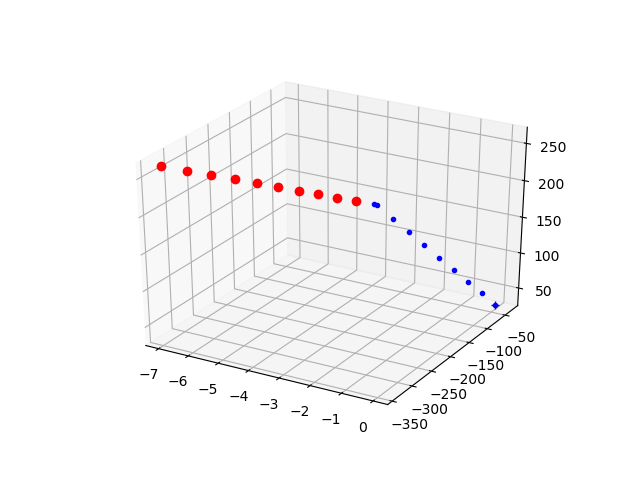

[[ 0.91146962 -0.20432318  0.06034066]
 [ 0.91146962 -0.20642542  0.06110189]
 [ 0.91146962 -0.19780377  0.05747137]
 [ 0.91146962 -0.18619645  0.05374716]
 [ 0.91146962 -0.2043559   0.05975509]
 [ 0.91146962 -0.21049085  0.06189826]
 [ 0.91146962 -0.19041729  0.05415706]
 [ 0.91146962 -0.20232728  0.05879476]
 [ 0.91146962 -0.19858087  0.05726057]
 [ 0.91146962 -0.20697348  0.05990734]]
Variable containing:
 0.9115 -0.2043  0.0603
 0.9115 -0.2064  0.0611
 0.9115 -0.1978  0.0575
 0.9115 -0.1862  0.0537
 0.9115 -0.2044  0.0598
 0.9115 -0.2105  0.0619
 0.9115 -0.1904  0.0542
 0.9115 -0.2023  0.0588
 0.9115 -0.1986  0.0573
 0.9115 -0.2070  0.0599
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.91055038 -0.16414463  0.04511882]
 [ 0.90967484 -0.14647415  0.03873603]
 [ 0.90858556 -0.12956045  0.0322066 ]
 [ 0.90756825 -0.11366206  0.02578512]
 [ 0.90672674 -0.09884615  0.01959539]
 [ 0.90611303 -0.08511966  0.01373361]
 [ 0.90574753 -0.07245936  0.00826981]
 [ 0.90563337 -0.060825

<IPython.core.display.Javascript object>


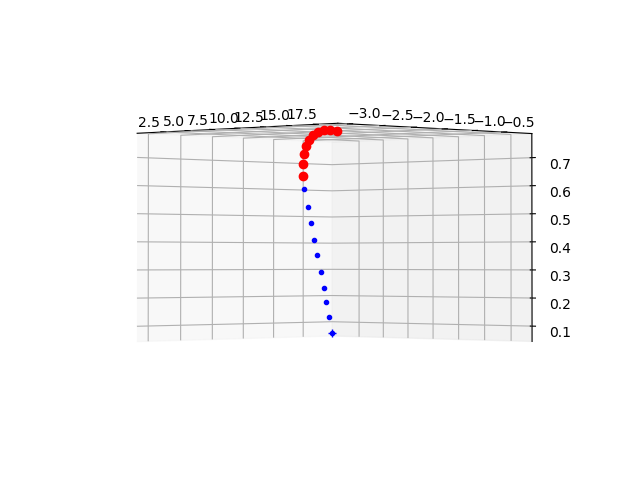

[[ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]]
Variable containing:
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
 0.9800  0.1700 -0.3129
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.98660962  0.14971166 -0.27591078]
 [ 0.98927198  0.14113685 -0.26049575]
 [ 0.99198002  0.13259221 -0.2450382 ]
 [ 0.99468838  0.12421731 -0.22977063]
 [ 0.99738677  0.11612228 -0.21489835]
 [ 1.0000546   0.10837897 -0.20055388]
 [ 1.00267123  0.10102808 -0.18681739]
 [ 1.00521757  0.094087

<IPython.core.display.Javascript object>


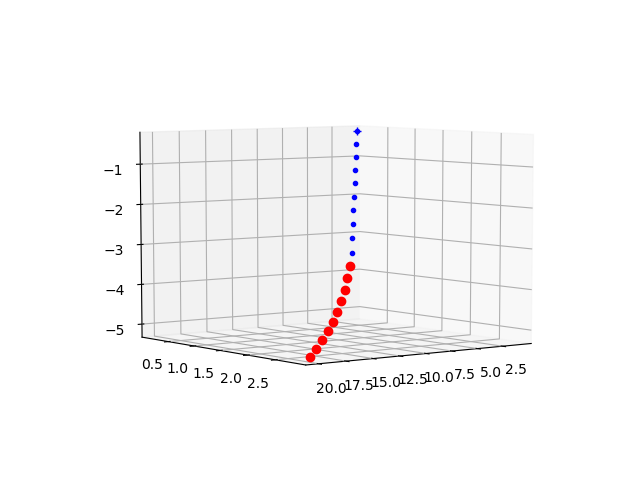

[[ 1.11216519 -0.18376796 -0.20035396]
 [ 1.11049273 -0.18540128 -0.20175933]
 [ 1.11049273 -0.18267908 -0.1989486 ]
 [ 1.11049273 -0.18812349 -0.20386737]
 [ 1.11049273 -0.18777702 -0.20604568]
 [ 1.11049273 -0.18356998 -0.20520246]
 [ 1.11049273 -0.18376796 -0.20527273]
 [ 1.11216519 -0.1870841  -0.20763842]
 [ 1.11216519 -0.17789047 -0.1993585 ]
 [ 1.11383765 -0.19340704 -0.21444272]]
Variable containing:
 1.1122 -0.1838 -0.2004
 1.1105 -0.1854 -0.2018
 1.1105 -0.1827 -0.1989
 1.1105 -0.1881 -0.2039
 1.1105 -0.1878 -0.2060
 1.1105 -0.1836 -0.2052
 1.1105 -0.1838 -0.2053
 1.1122 -0.1871 -0.2076
 1.1122 -0.1779 -0.1994
 1.1138 -0.1934 -0.2144
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.10737134 -0.16553769 -0.18360553]
 [ 1.10481062 -0.15503496 -0.17314399]
 [ 1.10200544 -0.14510737 -0.16286639]
 [ 1.09916114 -0.13590236 -0.15272048]
 [ 1.09635436 -0.12740301 -0.14278883]
 [ 1.09361965 -0.11955976 -0.13311958]
 [ 1.09097191 -0.11231627 -0.12374186]
 [ 1.08841577 -0.105617

<IPython.core.display.Javascript object>


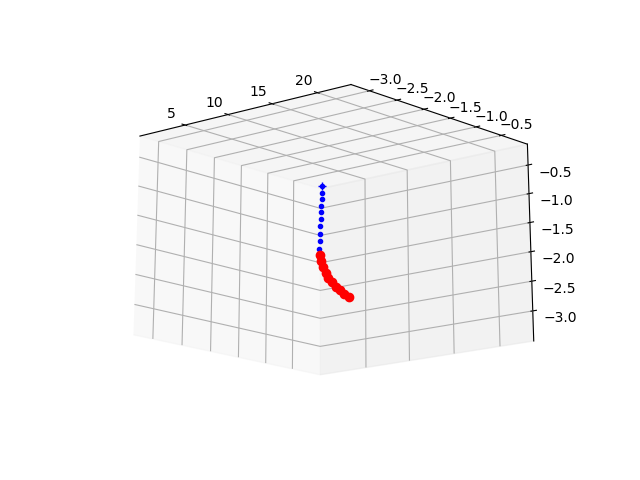

[[-0.51681383  0.18267892  0.05087788]
 [-0.53688339  0.21139203  0.06207394]
 [-0.55695295  0.1946971   0.05536333]
 [-0.57535004  0.19468351  0.0549183 ]
 [-0.59207467  0.18973485  0.05387599]
 [-0.60545437  0.18789949  0.07579963]
 [-0.61548915  0.16620152  0.11585245]
 [-0.62385147  0.13846726  0.13652298]
 [-0.62886886  0.13448386  0.13852562]
 [-0.65228334  0.13372253  0.13856075]]
Variable containing:
-0.5168  0.1827  0.0509
-0.5369  0.2114  0.0621
-0.5570  0.1947  0.0554
-0.5754  0.1947  0.0549
-0.5921  0.1897  0.0539
-0.6055  0.1879  0.0758
-0.6155  0.1662  0.1159
-0.6239  0.1385  0.1365
-0.6289  0.1345  0.1385
-0.6523  0.1337  0.1386
[torch.DoubleTensor of size 10x3]

Test prediction:
[[-0.6224454   0.05298011  0.1511475 ]
 [-0.61058502  0.01821303  0.15512105]
 [-0.59874272 -0.01554593  0.15859946]
 [-0.58699692 -0.04782016  0.16170205]
 [-0.57536705 -0.07830243  0.16431881]
 [-0.5638839  -0.10682505  0.16635328]
 [-0.55258025 -0.13331872  0.16773177]
 [-0.54148589 -0.157775

<IPython.core.display.Javascript object>


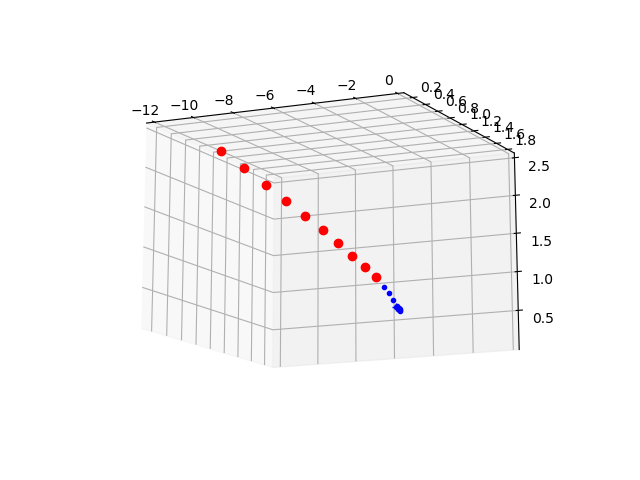

[[ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.02547873 -0.29296731]
 [ 1.11383765  0.02860495 -0.26008184]
 [ 1.11383765  0.02392276 -0.25656844]
 [ 1.11383765  0.02779128 -0.28631526]
 [ 1.11383765  0.02573568 -0.25947285]]
Variable containing:
 1.1138  0.0469 -0.5476
 1.1138  0.0469 -0.5476
 1.1138  0.0469 -0.5476
 1.1138  0.0469 -0.5476
 1.1138  0.0469 -0.5476
 1.1138  0.0255 -0.2930
 1.1138  0.0286 -0.2601
 1.1138  0.0239 -0.2566
 1.1138  0.0278 -0.2863
 1.1138  0.0257 -0.2595
[torch.DoubleTensor of size 10x3]

Test prediction:
[[  1.11419397e+00   1.58262004e-02  -2.24594350e-01]
 [  1.11380490e+00   1.18551032e-02  -2.09808229e-01]
 [  1.11326034e+00   7.98456730e-03  -1.95634425e-01]
 [  1.11257841e+00   4.25686031e-03  -1.82028062e-01]
 [  1.11177633e+00   7.06158356e-04  -1.68964622e-01]
 [  1.11086334e+00  -2.645

<IPython.core.display.Javascript object>


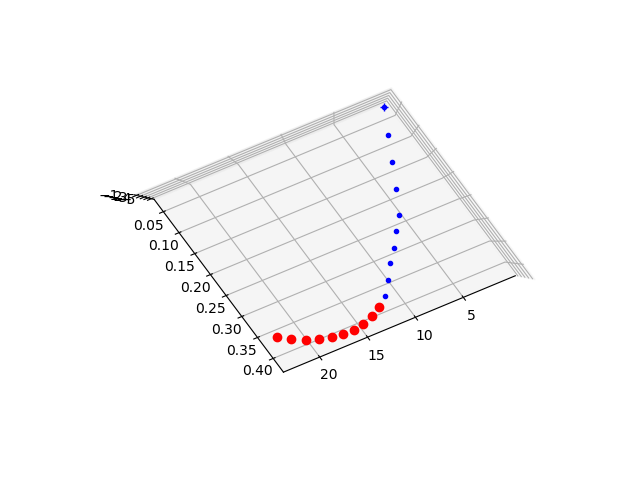

[[ 1.24930716  0.11269766 -0.28158388]
 [ 1.24930716  0.12878865 -0.31866201]
 [ 1.24930716  0.11860996 -0.29802661]
 [ 1.24930716  0.12456558 -0.3123613 ]
 [ 1.24930716  0.11967114 -0.29954909]
 [ 1.24930716  0.12116546 -0.30024006]
 [ 1.24930716  0.11921635 -0.29963107]
 [ 1.24930716  0.11962783 -0.29946711]
 [ 1.2476347   0.11867493 -0.29747618]
 [ 1.23759992  0.11070524 -0.27951097]]
Variable containing:
 1.2493  0.1127 -0.2816
 1.2493  0.1288 -0.3187
 1.2493  0.1186 -0.2980
 1.2493  0.1246 -0.3124
 1.2493  0.1197 -0.2995
 1.2493  0.1212 -0.3002
 1.2493  0.1192 -0.2996
 1.2493  0.1196 -0.2995
 1.2476  0.1187 -0.2975
 1.2376  0.1107 -0.2795
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.23287905  0.07941887 -0.25328483]
 [ 1.22939331  0.06541571 -0.2392912 ]
 [ 1.22588087  0.05195487 -0.22494552]
 [ 1.22228569  0.03920897 -0.21047154]
 [ 1.21859533  0.02726506 -0.19601724]
 [ 1.21480215  0.01616377 -0.18170211]
 [ 1.21090307  0.00591566 -0.16761929]
 [ 1.20689893 -0.003488

<IPython.core.display.Javascript object>


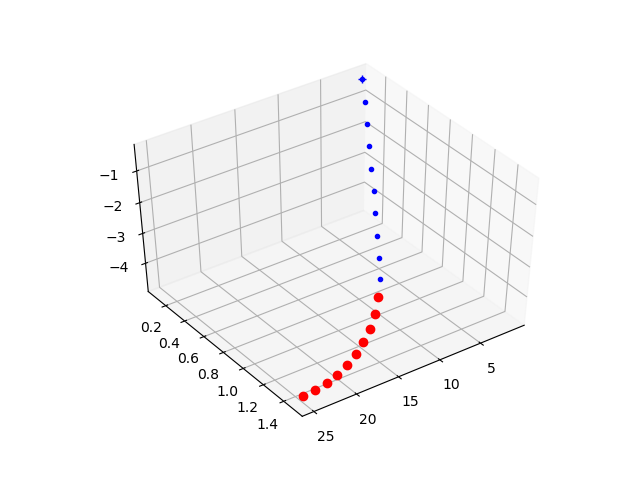

[[ -1.16907443e+00   9.73363763e-02  -8.29955835e-03]
 [ -1.14398748e+00   1.05645534e-01  -3.60330942e-03]
 [ -1.12726285e+00   9.59778448e-02  -5.75819611e-03]
 [ -1.11555561e+00   1.09057659e-01  -5.88702130e-03]
 [ -1.10050344e+00   1.13749332e-01  -3.38079141e-03]
 [ -1.08545127e+00   1.21173865e-01  -2.86549370e-03]
 [ -1.07207157e+00   1.26465818e-01  -5.88702130e-03]
 [ -1.06036433e+00   1.32752976e-01  -6.52048050e-04]
 [ -1.04029477e+00   1.56780027e-01  -7.92585025e-04]
 [ -1.02524260e+00   1.47538853e-01  -1.20354796e-02]]
Variable containing:
-1.1691  0.0973 -0.0083
-1.1440  0.1056 -0.0036
-1.1273  0.0960 -0.0058
-1.1156  0.1091 -0.0059
-1.1005  0.1137 -0.0034
-1.0855  0.1212 -0.0029
-1.0721  0.1265 -0.0059
-1.0604  0.1328 -0.0007
-1.0403  0.1568 -0.0008
-1.0252  0.1475 -0.0120
[torch.DoubleTensor of size 10x3]

Test prediction:
[[-1.03727171  0.09185903 -0.00500849]
 [-1.03870607  0.06504834 -0.0039487 ]
 [-1.03966934  0.03948429 -0.00337681]
 [-1.04053524  0.01564426 -0.

<IPython.core.display.Javascript object>


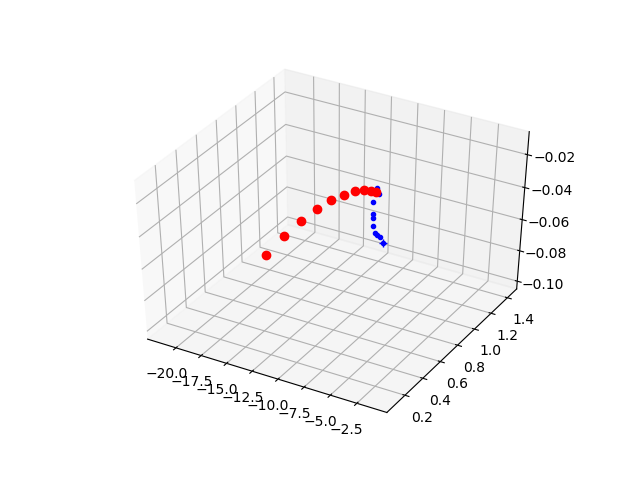

[[ 0.98004061  0.04793328 -0.31676477]
 [ 0.98004061  0.047919   -0.31770168]
 [ 0.98004061  0.04674846 -0.31348559]
 [ 0.98004061  0.04427888 -0.2958483 ]
 [ 0.98004061  0.0521444  -0.34728454]
 [ 0.98004061  0.04671991 -0.31261895]
 [ 0.98004061  0.04800465 -0.32096914]
 [ 0.97836815  0.04629166 -0.31198654]
 [ 0.97836815  0.04773343 -0.31750259]
 [ 0.97836815  0.04805836 -0.32167182]]
Variable containing:
 0.9800  0.0479 -0.3168
 0.9800  0.0479 -0.3177
 0.9800  0.0467 -0.3135
 0.9800  0.0443 -0.2958
 0.9800  0.0521 -0.3473
 0.9800  0.0467 -0.3126
 0.9800  0.0480 -0.3210
 0.9784  0.0463 -0.3120
 0.9784  0.0477 -0.3175
 0.9784  0.0481 -0.3217
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.98280191  0.04590835 -0.28463904]
 [ 0.98456366  0.0453296  -0.27003776]
 [ 0.98628872  0.04444316 -0.25543015]
 [ 0.98800666  0.04327787 -0.2409582 ]
 [ 0.9897394   0.04191982 -0.22681282]
 [ 0.99148581  0.04044489 -0.21311572]
 [ 0.9932374   0.03891172 -0.19994358]
 [ 0.99498279  0.037362

<IPython.core.display.Javascript object>


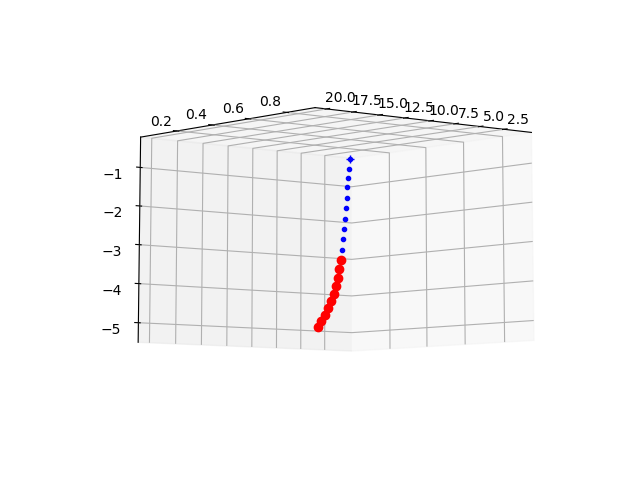

[[ 1.11383765  0.22909997 -0.2311431 ]
 [ 1.11383765  0.19468351 -0.19754324]
 [ 1.11383765  0.20861861 -0.21089418]
 [ 1.11383765  0.19942792 -0.2027665 ]
 [ 1.11383765  0.19897422 -0.20212238]
 [ 1.11383765  0.20738713 -0.21163199]
 [ 1.11383765  0.19858533 -0.20175933]
 [ 1.11383765  0.19693905 -0.20126745]
 [ 1.11551012  0.2113797  -0.21560214]
 [ 1.11551012  0.19635572 -0.20035396]]
Variable containing:
 1.1138  0.2291 -0.2311
 1.1138  0.1947 -0.1975
 1.1138  0.2086 -0.2109
 1.1138  0.1994 -0.2028
 1.1138  0.1990 -0.2021
 1.1138  0.2074 -0.2116
 1.1138  0.1986 -0.2018
 1.1138  0.1969 -0.2013
 1.1155  0.2114 -0.2156
 1.1155  0.1964 -0.2004
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.11772431  0.16665168 -0.17980676]
 [ 1.11847254  0.15240093 -0.16931475]
 [ 1.11911488  0.13847271 -0.15848329]
 [ 1.11960624  0.1250615  -0.14750877]
 [ 1.11992674  0.11227591 -0.13653356]
 [ 1.12006419  0.1001737  -0.12566617]
 [ 1.12001224  0.0887796  -0.11498636]
 [ 1.11976901  0.078097

<IPython.core.display.Javascript object>


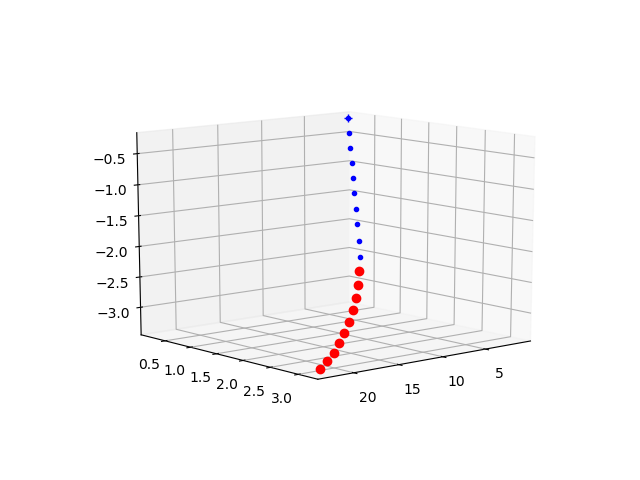

In [72]:
future = 10
test_pred = seq(test_input,future).data.squeeze(1).numpy()
test_pred_latlon = test_pred[:, :, -3:]
for i in range(test_input.size(0)//10):
    latlon = test_input[i].data.numpy()[:, -3:]
    print(latlon)
    latlon = np.insert(latlon, latlon.shape[0], test_pred_latlon[i], axis=0)
    path = latlon.cumsum(axis=0)
    print(test_input[i])
    print("Test prediction:")
    print(test_pred[i])
    print("Path including prediction")
    print(path)
    pathx, pathy, pathz = np.split(path, 3, axis=1)
    pathz = pathz.flatten()
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    ax.plot(pathx[0], pathy[0], pathz[0], 'b+')
    
    ax.plot(pathx[:-future], pathy[:-future], pathz[:-future], 'b.')
    
    for j in range(1,future+1):
        plt.plot(pathx[-j], pathy[-j], pathz[-j], 'ro')
    
    plt.show()

## How to save and load models in pytorch

In [67]:
# Self explanatory comment: Save only
torch.save(seq.state_dict(), 'ACAS_theparameters.pt')

In [68]:
# Self explanatory comment #2: Load only
seq1 = Sequence()
params = torch.load('ACAS_theparameters.pt')
seq1.load_state_dict(params)
seq1.double()

Sequence (
  (lstm1): LSTMCell(3, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear (51 -> 3)
)

## Making predictions and saving to csvs

- Denormalizes data according to model_stdevs.npy and model_means.npy
- Saves input sequences in "sequence/" folder, and their corresponding predictions in "prediction/" folder. 

torch.Size([100, 10, 3])
[[ 0.91146962 -0.20432318  0.06034066]
 [ 0.91146962 -0.20642542  0.06110189]
 [ 0.91146962 -0.19780377  0.05747137]
 [ 0.91146962 -0.18619645  0.05374716]
 [ 0.91146962 -0.2043559   0.05975509]
 [ 0.91146962 -0.21049085  0.06189826]
 [ 0.91146962 -0.19041729  0.05415706]
 [ 0.91146962 -0.20232728  0.05879476]
 [ 0.91146962 -0.19858087  0.05726057]
 [ 0.91146962 -0.20697348  0.05990734]]


<IPython.core.display.Javascript object>


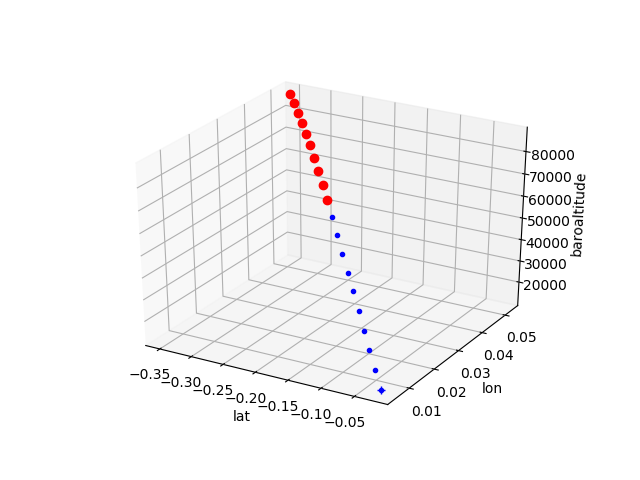

[[ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]
 [ 0.98004061  0.17000747 -0.31292345]]


<IPython.core.display.Javascript object>


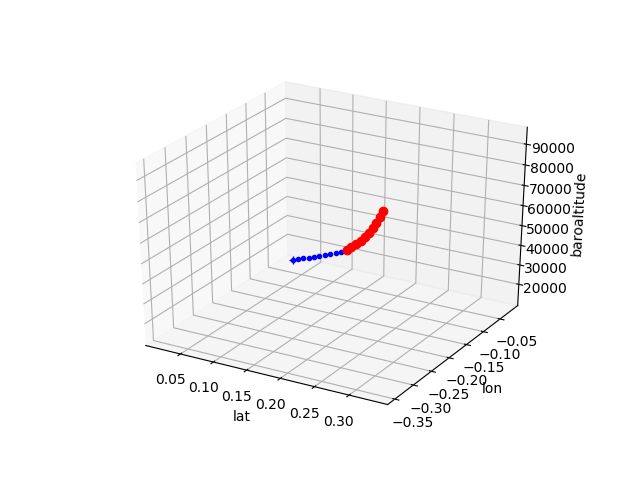

[[ 1.11216519 -0.18376796 -0.20035396]
 [ 1.11049273 -0.18540128 -0.20175933]
 [ 1.11049273 -0.18267908 -0.1989486 ]
 [ 1.11049273 -0.18812349 -0.20386737]
 [ 1.11049273 -0.18777702 -0.20604568]
 [ 1.11049273 -0.18356998 -0.20520246]
 [ 1.11049273 -0.18376796 -0.20527273]
 [ 1.11216519 -0.1870841  -0.20763842]
 [ 1.11216519 -0.17789047 -0.1993585 ]
 [ 1.11383765 -0.19340704 -0.21444272]]


<IPython.core.display.Javascript object>


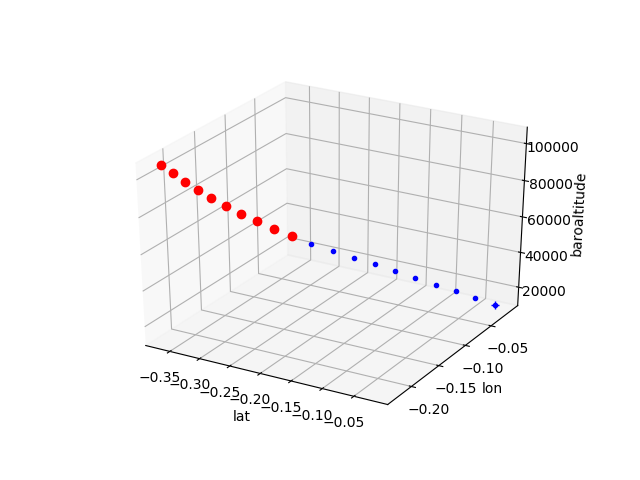

[[-0.51681383  0.18267892  0.05087788]
 [-0.53688339  0.21139203  0.06207394]
 [-0.55695295  0.1946971   0.05536333]
 [-0.57535004  0.19468351  0.0549183 ]
 [-0.59207467  0.18973485  0.05387599]
 [-0.60545437  0.18789949  0.07579963]
 [-0.61548915  0.16620152  0.11585245]
 [-0.62385147  0.13846726  0.13652298]
 [-0.62886886  0.13448386  0.13852562]
 [-0.65228334  0.13372253  0.13856075]]


<IPython.core.display.Javascript object>


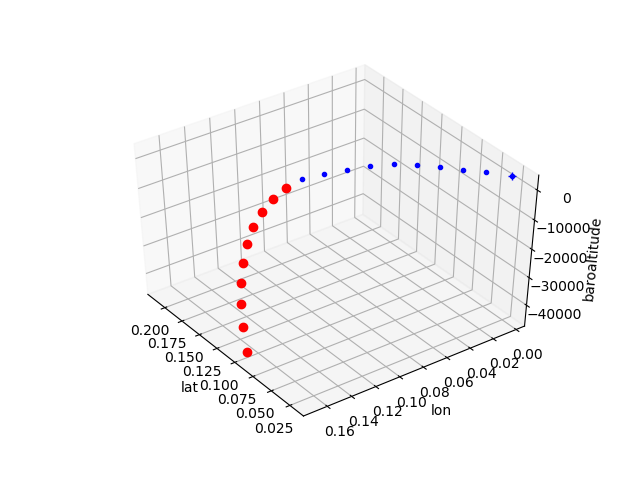

[[ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.04686266 -0.54760716]
 [ 1.11383765  0.02547873 -0.29296731]
 [ 1.11383765  0.02860495 -0.26008184]
 [ 1.11383765  0.02392276 -0.25656844]
 [ 1.11383765  0.02779128 -0.28631526]
 [ 1.11383765  0.02573568 -0.25947285]]


<IPython.core.display.Javascript object>


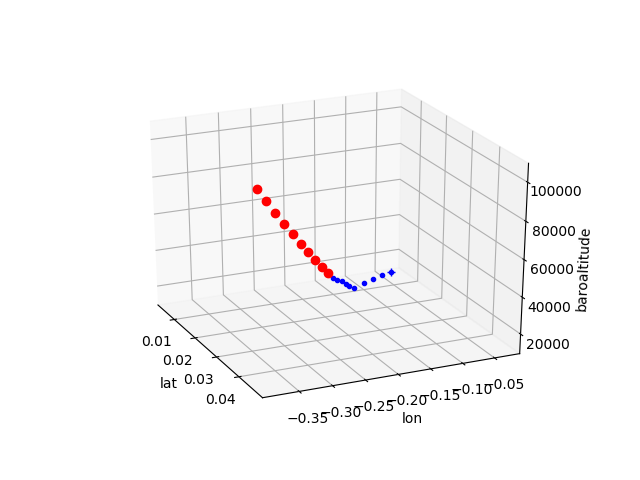

[[ 1.24930716  0.11269766 -0.28158388]
 [ 1.24930716  0.12878865 -0.31866201]
 [ 1.24930716  0.11860996 -0.29802661]
 [ 1.24930716  0.12456558 -0.3123613 ]
 [ 1.24930716  0.11967114 -0.29954909]
 [ 1.24930716  0.12116546 -0.30024006]
 [ 1.24930716  0.11921635 -0.29963107]
 [ 1.24930716  0.11962783 -0.29946711]
 [ 1.2476347   0.11867493 -0.29747618]
 [ 1.23759992  0.11070524 -0.27951097]]


<IPython.core.display.Javascript object>


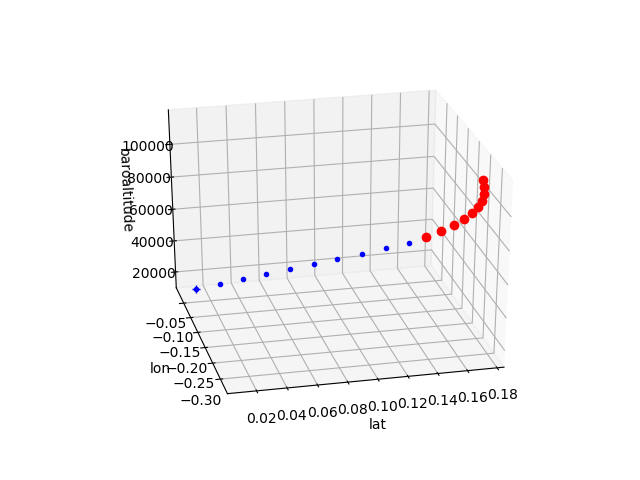

[[ -1.16907443e+00   9.73363763e-02  -8.29955835e-03]
 [ -1.14398748e+00   1.05645534e-01  -3.60330942e-03]
 [ -1.12726285e+00   9.59778448e-02  -5.75819611e-03]
 [ -1.11555561e+00   1.09057659e-01  -5.88702130e-03]
 [ -1.10050344e+00   1.13749332e-01  -3.38079141e-03]
 [ -1.08545127e+00   1.21173865e-01  -2.86549370e-03]
 [ -1.07207157e+00   1.26465818e-01  -5.88702130e-03]
 [ -1.06036433e+00   1.32752976e-01  -6.52048050e-04]
 [ -1.04029477e+00   1.56780027e-01  -7.92585025e-04]
 [ -1.02524260e+00   1.47538853e-01  -1.20354796e-02]]


<IPython.core.display.Javascript object>


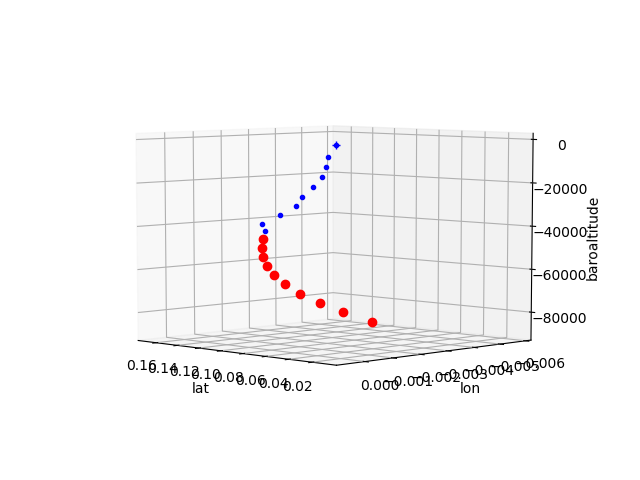

[[ 0.98004061  0.04793328 -0.31676477]
 [ 0.98004061  0.047919   -0.31770168]
 [ 0.98004061  0.04674846 -0.31348559]
 [ 0.98004061  0.04427888 -0.2958483 ]
 [ 0.98004061  0.0521444  -0.34728454]
 [ 0.98004061  0.04671991 -0.31261895]
 [ 0.98004061  0.04800465 -0.32096914]
 [ 0.97836815  0.04629166 -0.31198654]
 [ 0.97836815  0.04773343 -0.31750259]
 [ 0.97836815  0.04805836 -0.32167182]]


<IPython.core.display.Javascript object>


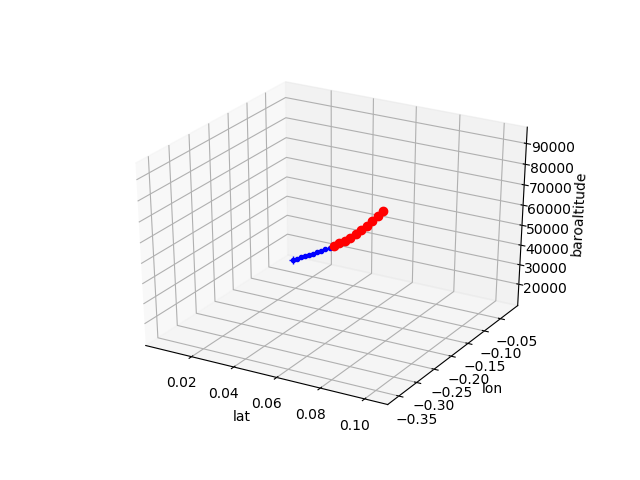

[[ 1.11383765  0.22909997 -0.2311431 ]
 [ 1.11383765  0.19468351 -0.19754324]
 [ 1.11383765  0.20861861 -0.21089418]
 [ 1.11383765  0.19942792 -0.2027665 ]
 [ 1.11383765  0.19897422 -0.20212238]
 [ 1.11383765  0.20738713 -0.21163199]
 [ 1.11383765  0.19858533 -0.20175933]
 [ 1.11383765  0.19693905 -0.20126745]
 [ 1.11551012  0.2113797  -0.21560214]
 [ 1.11551012  0.19635572 -0.20035396]]


<IPython.core.display.Javascript object>


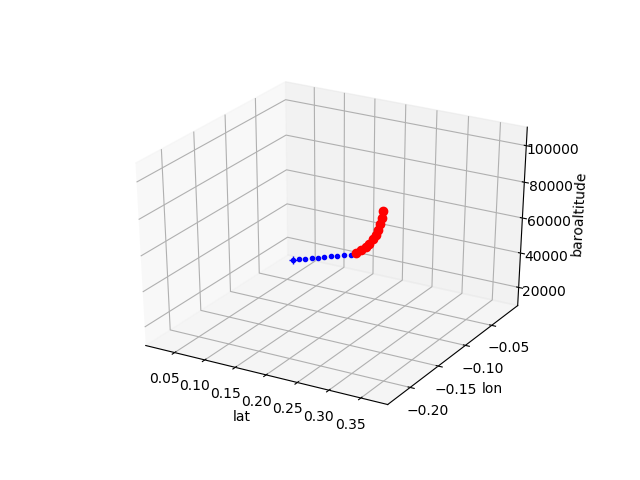

In [153]:
def denormalize(path):
    path *= np.load("model_stdevs.npy")
    path += np.load("model_means.npy")
    
    return path

print(np.load("model_means.npy"))

# write to csv file
sequence_dir = 'sequences/'
pred_dir = 'predictions/'
if not os.path.exists(sequence_dir):
    os.makedirs(sequence_dir)
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

pred_df = pd.DataFrame(columns=['baroaltitude','lat','lon'])
future = 10
test_pred = seq(test_input,future).data.squeeze(1).numpy()
test_pred_latlon = test_pred[:, :, -3:]
for i in range(1,test_input.size(0)//10):
    latlon = test_input[i].data.numpy()[:, -3:]
    print(latlon)
    latlon = np.insert(latlon, latlon.shape[0], test_pred_latlon[i], axis=0)
    path = latlon.cumsum(axis=0)
    path = denormalize(path)
    pathz, pathx, pathy = np.split(path, 3, axis=1)
    pathz = pathz.flatten()
    
#     print("all data")
#     print(pathx)
#     print("just input data")
#     print(pathx[:-future])
    
    one_seq_df = pd.DataFrame(path[:-future], columns = ['baroaltitude', 'lat', 'lon'])
    one_pred_df = pd.DataFrame(path[future:], columns = ['baroaltitude', 'lat', 'lon'])
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel('lat')
    ax.set_ylabel('lon')
    ax.set_zlabel('baroaltitude')
    
    ax.plot(pathx[0], pathy[0], pathz[0], 'b+') # plot first sequence point
    ax.plot(pathx[:-future], pathy[:-future], pathz[:-future], 'b.') # plot other sequence points
    
    # plot predicted points
    for j in range(1,future+1):
        plt.plot(pathx[-j], pathy[-j], pathz[-j], 'ro')
    
    plt.show()
    
    #pred_df = pred_df.append(one_sequence_df, ignore_index=True)
    
    
    one_seq_df.to_csv(sequence_dir + "sequence_" + str(i) + ".csv", index=False)
    one_pred_df.to_csv(pred_dir + "sequence-pred_" + str(i) + ".csv", index=False)
    